# Task D:  Predictive Data Analysis using R
I need to train a machine learning model on dialogue utterance vs dialogue usefulness. 

The data files I have, with the descriptions of their columns are:
dialogue_utterance_train/validation/test.csv 
Dialogue_ID - The unique ID of a dialogue 
Usefulness_score - This score is given by a student to indicate their perceived 
usefulness of the FLoRA chatbot when answering the post-task 
questionnaire Question 3 (i.e., “To what extent do you think the 
GPT-powered chatbot on FLoRA is useful for you to accomplish 
the assignment?”). The value range of this feature is [1,5], with 1 
representing “very unuseful”, 2 representing “unuseful”, 3 
representing “neutral”, 4 representing “useful”, and 5 
representing “very useful”.

dialogue_usefulness_train/validation/test.csv
Column Name - Description 
Dialogue_ID - The unique ID of a dialogue 
Timestamp - When an utterance contained in the dialogue was made 
Interlocutor - Whether the utterance was made by the student or the chatbot ("Student"/"Chatbot")
Utterance_text - The text of the utterance

dialogue_utterance_train has 117k lines, split over 303 unique dialogue IDs.
1.  What  features  can  you  engineer  to  empower  the  training  of  a  machine  learning model? You may propose as many as you believe are useful. Please note that the number of the features should not exceed the number of the dialogues contained in the training set. Otherwise, the constructed machine learning models are prone to have overfitting issues. Select two features that you propose and try to use boxplots to visualise  the  feature  value  between  the following two groups of dialogues in the training  set:  (i)  those  with  Usefulness_score  of  1  or  2;  and  (ii)  those  with Usefulness_score  of  4  or  5.  Show if there  any  difference  between  the  two  groups  of dialogues? How can you tell whether the difference is statistically significant? Ideally, identify features that display statistically significant differences. 
 
2.  Build a machine learning model (e.g., polynomial regressions, regression tree) based on the training set by taking all the features that you have proposed and evaluate the performance of the model on the validation set using the relevant evaluation metrics you learned in class. Aim to include at least 5 features in this model. The best-performing model here is denoted as Model 1. 
3.  Now we want to improve the performance of Model 1 (i.e., to get a more accurate model).  For  example,  you  may  try  some  of the following methods to improve a model: 
●  Select  a  subset  of  the  features  (especially  the  important  ones  in  your opinions) as input to empower a machine learning model or a subset of the 
data in a dialogue (given that some questions asked by students might not be 
directly relevant to solving the assignment). 
●  Deal with errors (e.g.: filtering out data outliers). 
●  Rescale  data  (i.e.,  bringing  different  variables  with  different  scales  to  a common scale). 
●  Transform data (i.e., transforming the distribution of variables). 
●  Try other machine learning algorithms that you know. 
 
Please build the predictive models by trying some of the above methods or some other methods you can think of and evaluate the performance of the models and report whether Model 1 can be improved. 
Explain how you have improved your model by including code, output, 
and  explanations  (explaining  the  code  or the process) and justify why you have chosen some of the above methods or some other methods to improve a model 
(e.g., why this subset of the variables are chosen to build a model). 
4.  What is the Dialogue_ID of the dialogue you generated? Please copy and paste the whole  dialogue  text  that  you  generated  with  the  chatbot  here.  With  the best-performing model constructed from Question 2&3, what is the prediction value for the dialogue you generated? Is the prediction value close to the groundtruth value? 
If yes, what features do you think play important roles here to enable the model to successfully make the prediction? How can you determine the importance of features quantitatively? If not, what might be the reasons? For students whose dialogues are included in the test set, you may randomly select a dialogue from the validation set to analyse and answer this question. 
5.  The  groundtruth  Usefulness_score  values  in  the  file “dialogue_usefulness_test.csv” are unavailable now. Here, your task is to use the best-performing model constructed from Question 2&3 to predict the usefulness of the dialogues contained in the  test  set.  You  need  to  populate  your  prediction  results  (i.e.,  the  predicted Usefulness_score values) into the file “dialogue_usefulness_test.csv” and upload it to Moodle to measure the overall performance of your model. Please ensure the number of  columns  and  rows  remains  the  same  as  in  the  original  file (dialogue_usefulness_test.csv),  and  only  fill  in  the  prediction  results  in  the 'Usefulness_score'  column.  Please  name  the  submission  file  using  the  following format: LastName_StudentNumber_dialogue_usefulness_test.csv. 

The performance level of the model will be measured by RMSE.


--- Statistical Significance Tests ---
Feature: total_dialogue_length_words - T-test p-value: 7e-04 
Feature: avg_readability_score_student - T-test p-value: 0.1623 


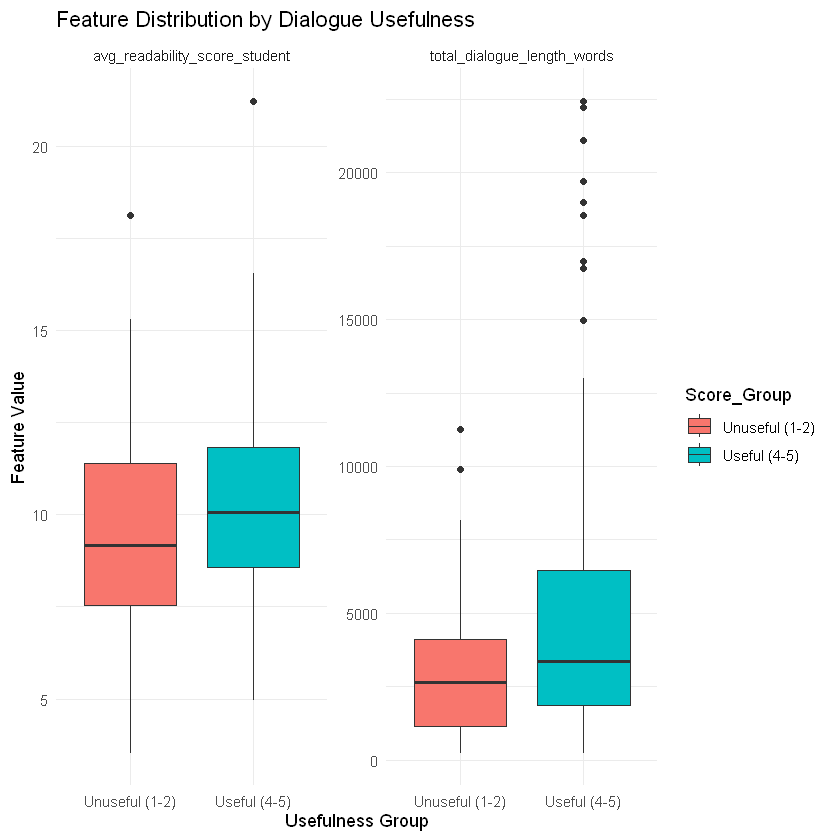

In [13]:
# --- Load All Necessary Packages ---
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("lubridate", quietly = TRUE)) install.packages("lubridate")
if (!requireNamespace("stringr", quietly = TRUE)) install.packages("stringr")
if (!requireNamespace("quanteda", quietly = TRUE)) install.packages("quanteda")
if (!requireNamespace("quanteda.textstats", quietly = TRUE)) install.packages("quanteda.textstats")

library(dplyr)
library(ggplot2)
library(lubridate)
library(stringr)
library(quanteda)
library(quanteda.textstats)

# --- Load Training Data ---
df_utterance_train <- read.csv("git_ignore/dialogue_utterance_train.csv")
df_usefulness_train <- read.csv("git_ignore/dialogue_usefulness_train.csv")

# Merge dataframes and sort
df_merged_train <- left_join(df_utterance_train, df_usefulness_train, by = "Dialogue_ID") %>%
    mutate(Timestamp = ymd_hms(Timestamp)) %>%
    arrange(Dialogue_ID, Timestamp)

# --- Feature Engineering Functions ---
# Function to calculate readability per utterance
calculate_readability <- function(df) {
    df$utterance_id <- paste0("utt_", 1:nrow(df))
    utterance_corpus <- corpus(df, text_field = "Utterance_text", docid_field = "utterance_id")
    if (ndoc(utterance_corpus) > 0) {
        readability_scores <- textstat_readability(utterance_corpus, measure = "Flesch.Kincaid") %>%
            select(document, Flesch.Kincaid) %>%
            rename(utterance_id = document, readability_score = Flesch.Kincaid)
        df <- left_join(df, readability_scores, by = "utterance_id")
        df$readability_score[is.na(df$readability_score)] <- 0
    }
    return(df)
}

# Function to engineer all 17 features per dialogue
engineer_features <- function(df_with_readability) {
    dialogue_features_df <- df_with_readability %>%
        group_by(Dialogue_ID) %>%
        summarise(
            num_utterances = n(),
            total_dialogue_length_words = sum(sapply(str_split(Utterance_text, "\\s+"), length), na.rm = TRUE),
            dialogue_duration = as.numeric(difftime(max(Timestamp), min(Timestamp), units = "secs")),
            avg_len_student_utterance_words = mean(sapply(str_split(Utterance_text[Interlocutor == "Student"], "\\s+"), length), na.rm = TRUE),
            avg_len_chatbot_utterance_words = mean(sapply(str_split(Utterance_text[Interlocutor == "Chatbot"], "\\s+"), length), na.rm = TRUE),
            num_student_questions = sum(str_detect(Utterance_text[Interlocutor == "Student"], "\\?"), na.rm = TRUE),
            num_chatbot_questions = sum(str_detect(Utterance_text[Interlocutor == "Chatbot"], "\\?"), na.rm = TRUE),
            all_student_words = list(unlist(str_split(paste(Utterance_text[Interlocutor == "Student"], collapse = " "), "\\s+"))),
            all_chatbot_words = list(unlist(str_split(paste(Utterance_text[Interlocutor == "Chatbot"], collapse = " "), "\\s+"))),
            avg_readability_score_student = mean(readability_score[Interlocutor == "Student"], na.rm = TRUE),
            avg_readability_score_chatbot = mean(readability_score[Interlocutor == "Chatbot"], na.rm = TRUE),
            time_diffs_raw = list(as.numeric(diff(Timestamp), units = "secs"))
        ) %>%
        mutate(
            num_unique_words_student = sapply(all_student_words, function(x) length(unique(x[x != "" & !is.na(x)]))),
            num_unique_words_chatbot = sapply(all_chatbot_words, function(x) length(unique(x[x != "" & !is.na(x)]))),
            total_words_student = sapply(all_student_words, function(x) length(x[x != "" & !is.na(x)])),
            total_words_chatbot = sapply(all_chatbot_words, function(x) length(x[x != "" & !is.na(x)])),
            ttr_student = ifelse(total_words_student > 0, num_unique_words_student / total_words_student, 0),
            ttr_chatbot = ifelse(total_words_chatbot > 0, num_unique_words_chatbot / total_words_chatbot, 0),
            variance_time_between_utterances = sapply(time_diffs_raw, function(x) ifelse(length(x) > 1, var(x, na.rm = TRUE), 0)),
            ratio_student_chatbot_len_words = ifelse(avg_len_chatbot_utterance_words > 0, avg_len_student_utterance_words / avg_len_chatbot_utterance_words, Inf)
        ) %>%
        select(-all_student_words, -all_chatbot_words, -time_diffs_raw)

    df_usefulness_scores_unique <- df_with_readability %>% select(Dialogue_ID, Usefulness_score) %>% distinct()
    dialogue_features_df <- left_join(dialogue_features_df, df_usefulness_scores_unique, by = "Dialogue_ID")
    return(dialogue_features_df)
}

# --- Execute Feature Engineering ---
df_merged_train_readable <- calculate_readability(df_merged_train)
dialogue_features_train_raw <- engineer_features(df_merged_train_readable)

# --- Visualization & Statistical Tests ---
# We select two promising features: total words and student readability.
selected_features_vis <- c("total_dialogue_length_words", "avg_readability_score_student")

# Create groups for plotting
plot_data <- dialogue_features_train_raw %>%
  filter(Usefulness_score %in% c(1, 2, 4, 5)) %>%
  mutate(Score_Group = ifelse(Usefulness_score %in% c(1, 2), "Unuseful (1-2)", "Useful (4-5)")) %>%
  select(all_of(selected_features_vis), Score_Group) %>%
  tidyr::gather(key = "Feature", value = "Value", -Score_Group)

# Boxplot
ggplot(plot_data, aes(x = Score_Group, y = Value, fill = Score_Group)) +
    geom_boxplot() +
    facet_wrap(~Feature, scales = "free_y") +
    labs(title = "Feature Distribution by Dialogue Usefulness", x = "Usefulness Group", y = "Feature Value") +
    theme_minimal()

# T-tests
cat("\n--- Statistical Significance Tests ---\n")
for (feature in selected_features_vis) {
    group1_data <- dialogue_features_train_raw %>% filter(Usefulness_score %in% c(1, 2)) %>% pull(!!feature)
    group2_data <- dialogue_features_train_raw %>% filter(Usefulness_score %in% c(4, 5)) %>% pull(!!feature)
    if (length(na.omit(group1_data)) > 1 && length(na.omit(group2_data)) > 1) {
        ttest_result <- t.test(group1_data, group2_data)
        cat(paste("Feature:", feature, "- T-test p-value:", round(ttest_result$p.value, 4), "\n"))
    }
}

In [17]:
# Install and load necessary packages
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("lubridate", quietly = TRUE)) install.packages("lubridate")
if (!requireNamespace("stringr", quietly = TRUE)) install.packages("stringr")
if (!requireNamespace("caret", quietly = TRUE)) install.packages("caret") # For model training and evaluation
if (!requireNamespace("randomForest", quietly = TRUE)) install.packages("randomForest") # For Random Forest
if (!requireNamespace("e1071", quietly = TRUE)) install.packages("e1071") # For SVR
if (!requireNamespace("rpart", quietly = TRUE)) install.packages("rpart") # For Regression Tree
if (!requireNamespace("rpart.plot", quietly = TRUE)) install.packages("rpart.plot") # For plotting regression tree
# New packages for advanced text features
if (!requireNamespace("quanteda", quietly = TRUE)) install.packages("quanteda")
if (!requireNamespace("quanteda.textstats", quietly = TRUE)) install.packages("quanteda.textstats")


library(dplyr)
library(lubridate)
library(stringr)
library(caret)
library(randomForest)
library(e1071)
library(rpart)
library(rpart.plot)
library(quanteda)
library(quanteda.textstats)


# --- Load Training and Validation Data ---
df_utterance_train <- read.csv("git_ignore/dialogue_utterance_train.csv")
df_usefulness_train <- read.csv("git_ignore/dialogue_usefulness_train.csv")
df_utterance_validation <- read.csv("git_ignore/dialogue_utterance_validation.csv")
df_usefulness_validation <- read.csv("git_ignore/dialogue_usefulness_validation.csv")

# Merge the dataframes on Dialogue_ID
df_merged_train <- left_join(df_utterance_train, df_usefulness_train, by = "Dialogue_ID")
df_merged_validation <- left_join(df_utterance_validation, df_usefulness_validation, by = "Dialogue_ID")

# Convert Timestamp to datetime objects
df_merged_train$Timestamp <- ymd_hms(df_merged_train$Timestamp)
df_merged_validation$Timestamp <- ymd_hms(df_merged_validation$Timestamp)

# Sort by Dialogue_ID and Timestamp for accurate sequential calculations
df_merged_train <- df_merged_train %>% arrange(Dialogue_ID, Timestamp)
df_merged_validation <- df_merged_validation %>% arrange(Dialogue_ID, Timestamp)


# --- New Feature Engineering Steps ---

# Step 1: Calculate Readability Scores per Utterance
# Create a unique ID for each utterance to be used as docid in quanteda corpus
df_merged_train$utterance_id <- paste0("train_utt_", 1:nrow(df_merged_train))
df_merged_validation$utterance_id <- paste0("val_utt_", 1:nrow(df_merged_validation))

calculate_readability <- function(df_merged_data) {
    # Create a corpus from the merged data, using 'utterance_id' as document IDs
    utterance_corpus <- corpus(df_merged_data, text_field = "Utterance_text", docid_field = "utterance_id")

    readability_scores <- data.frame(utterance_id = character(), readability_score = numeric(), stringsAsFactors = FALSE)

    # Check if the corpus is not empty
    if (ndoc(utterance_corpus) > 0) {
        # Calculate Flesch-Kincaid readability for each document (utterance) in the corpus
        # textstat_readability works directly on a corpus object
        readability_results <- textstat_readability(utterance_corpus, measure = "Flesch.Kincaid") %>%
            select(document, Flesch.Kincaid) %>%
            rename(utterance_id = document, readability_score = Flesch.Kincaid)

        readability_scores <- readability_results
    }


    # Join back to the original merged dataframe
    # Ensure all original utterances are kept, with NA for those without readability score (e.g., empty text)
    df_with_readability <- left_join(df_merged_data, readability_scores, by = "utterance_id")

    # Fill NA readability scores with 0 or a reasonable default (e.g., if utterance was empty or calculation failed)
    df_with_readability$readability_score[is.na(df_with_readability$readability_score)] <- 0
    return(df_with_readability)
}

df_merged_train_with_readability <- calculate_readability(df_merged_train)
df_merged_validation_with_readability <- calculate_readability(df_merged_validation)


# Step 2: Function to engineer all features for a given dataframe
engineer_features <- function(df_merged_data_with_readability) {
    dialogue_features_df <- df_merged_data_with_readability %>%
        group_by(Dialogue_ID) %>%
        summarise(
            num_utterances = n(),

            # Changed to word count
            total_dialogue_length_words = sum(sapply(str_split(Utterance_text, "\\s+"), length), na.rm = TRUE),
            dialogue_duration = as.numeric(difftime(max(Timestamp), min(Timestamp), units = "secs")),

            # Changed to word count
            avg_len_student_utterance_words = mean(sapply(str_split(Utterance_text[Interlocutor == "Student"], "\\s+"), length), na.rm = TRUE),
            avg_len_chatbot_utterance_words = mean(sapply(str_split(Utterance_text[Interlocutor == "Chatbot"], "\\s+"), length), na.rm = TRUE),
            num_student_questions = sum(str_detect(Utterance_text[Interlocutor == "Student"], "\\?"), na.rm = TRUE),
            num_chatbot_questions = sum(str_detect(Utterance_text[Interlocutor == "Chatbot"], "\\?"), na.rm = TRUE),

            # New: Lexical Richness/Diversity (by dialogue, per interlocutor)
            # Collect all words from student/chatbot utterances in this dialogue
            all_student_words = list(unlist(str_split(paste(Utterance_text[Interlocutor == "Student"], collapse = " "), "\\s+"))),
            all_chatbot_words = list(unlist(str_split(paste(Utterance_text[Interlocutor == "Chatbot"], collapse = " "), "\\s+"))),

            # New: Average Readability Scores per interlocutor (averaged over their utterances in the dialogue)
            avg_readability_score_student = mean(readability_score[Interlocutor == "Student"], na.rm = TRUE),
            avg_readability_score_chatbot = mean(readability_score[Interlocutor == "Chatbot"], na.rm = TRUE),

            # New: Turn-taking and Interruption Metrics
            time_diffs_raw = list(as.numeric(diff(Timestamp), units = "secs"))
        )

    # Post-summarize calculations for features that need list columns or additional processing
    dialogue_features_df <- dialogue_features_df %>%
        mutate(
            # Lexical Richness/Diversity continued
            # Filter out empty strings from word lists before counting unique words
            num_unique_words_student = sapply(all_student_words, function(x) length(unique(x[x != "" & !is.na(x)]))),
            num_unique_words_chatbot = sapply(all_chatbot_words, function(x) length(unique(x[x != "" & !is.na(x)]))),

            # Calculate total words for TTR accurately for the entire dialogue for each interlocutor
            total_words_student = sapply(all_student_words, function(x) length(x[x != "" & !is.na(x)])),
            total_words_chatbot = sapply(all_chatbot_words, function(x) length(x[x != "" & !is.na(x)])),

            # Calculate TTR, handle division by zero
            ttr_student = ifelse(total_words_student > 0, num_unique_words_student / total_words_student, 0),
            ttr_chatbot = ifelse(total_words_chatbot > 0, num_unique_words_chatbot / total_words_chatbot, 0),

            # Turn-taking and Interruption Metrics continued (Variance of time between utterances)
            # Ensure there's enough data points for variance calculation (at least 2 time differences, so 3 utterances)
            variance_time_between_utterances = sapply(time_diffs_raw, function(x) ifelse(length(x) > 1, var(x, na.rm = TRUE), 0))
        ) %>%
        select(-all_student_words, -all_chatbot_words, -time_diffs_raw) # Remove temporary list columns

    # Re-calculate ratio_student_chatbot_len based on word counts
    dialogue_features_df <- dialogue_features_df %>%
        mutate(
            ratio_student_chatbot_len_words = ifelse(avg_len_chatbot_utterance_words > 0, avg_len_student_utterance_words / avg_len_chatbot_utterance_words,
                ifelse(avg_len_student_utterance_words > 0, Inf, 0)
            ) # Handle division by zero
        )

    # Add Usefulness_score to the dialogue features dataframe
    df_usefulness_scores_unique <- df_merged_data_with_readability %>%
        select(Dialogue_ID, Usefulness_score) %>%
        distinct()
    dialogue_features_df <- left_join(dialogue_features_df, df_usefulness_scores_unique, by = "Dialogue_ID")

    return(dialogue_features_df)
}

dialogue_features_train <- engineer_features(df_merged_train_with_readability)
dialogue_features_validation <- engineer_features(df_merged_validation_with_readability)


# --- Handle Inf and NA values in engineered features ---
# Identify features for training (all engineered features except Dialogue_ID and Usefulness_score)
features_to_use <- setdiff(names(dialogue_features_train), c("Dialogue_ID", "Usefulness_score"))

for (col in features_to_use) {
    # Convert to numeric if not already (important for Inf/NA checks)
    dialogue_features_train[[col]] <- as.numeric(dialogue_features_train[[col]])
    dialogue_features_validation[[col]] <- as.numeric(dialogue_features_validation[[col]])

    # Handling Inf values
    if (any(is.infinite(dialogue_features_train[[col]]))) {
        max_finite_val_train <- max(dialogue_features_train[[col]][is.finite(dialogue_features_train[[col]])], na.rm = TRUE)
        if (is.infinite(max_finite_val_train) || is.na(max_finite_val_train)) {
            dialogue_features_train[[col]][is.infinite(dialogue_features_train[[col]])] <- 1000 # Default if no finite values
        } else {
            dialogue_features_train[[col]][is.infinite(dialogue_features_train[[col]])] <- max_finite_val_train + 1
        }
    }

    if (any(is.infinite(dialogue_features_validation[[col]]))) {
        # Use the max finite value from the training set for validation set to prevent data leakage
        max_finite_val_validation_ref <- max(dialogue_features_train[[col]][is.finite(dialogue_features_train[[col]])], na.rm = TRUE)
        if (is.infinite(max_finite_val_validation_ref) || is.na(max_finite_val_validation_ref)) {
            dialogue_features_validation[[col]][is.infinite(dialogue_features_validation[[col]])] <- 1000
        } else {
            dialogue_features_validation[[col]][is.infinite(dialogue_features_validation[[col]])] <- max_finite_val_validation_ref + 1
        }
    }

    # Impute NA values using the mean from the training data for both train and validation
    mean_val_train <- mean(dialogue_features_train[[col]], na.rm = TRUE)
    dialogue_features_train[[col]][is.na(dialogue_features_train[[col]])] <- mean_val_train

    # Use training mean for validation set to prevent data leakage
    dialogue_features_validation[[col]][is.na(dialogue_features_validation[[col]])] <- mean_val_train
}

# Ensure Usefulness_score is numeric and remove any NAs/Infs from the target variable
dialogue_features_train$Usefulness_score <- as.numeric(dialogue_features_train$Usefulness_score)
dialogue_features_validation$Usefulness_score <- as.numeric(dialogue_features_validation$Usefulness_score)

dialogue_features_train <- dialogue_features_train[!is.na(dialogue_features_train$Usefulness_score) & !is.infinite(dialogue_features_train$Usefulness_score), ]
dialogue_features_validation <- dialogue_features_validation[!is.na(dialogue_features_validation$Usefulness_score) & !is.infinite(dialogue_features_validation$Usefulness_score), ]

# Verify the number of features does not exceed 303 (number of unique dialogues)
# Exclude Dialogue_ID and Usefulness_score from the count
num_engineered_features_updated <- ncol(dialogue_features_train) - 2
num_unique_dialogues_train <- n_distinct(dialogue_features_train$Dialogue_ID)

cat(paste0("\nNumber of engineered features (updated): ", num_engineered_features_updated, "\n"))
cat(paste0("Number of unique dialogues in training set: ", num_unique_dialogues_train, "\n"))
cat(paste0("All engineered features (updated): ", paste(setdiff(names(dialogue_features_train), c("Dialogue_ID", "Usefulness_score")), collapse = ", "), "\n\n"))


# --- Model Training and Evaluation (Same as before, but with new features) ---

results <- list()

# Define RMSE and MAE function
RMSE <- function(y_true, y_pred) {
    sqrt(mean((y_true - y_pred)^2))
}

MAE <- function(y_true, y_pred) {
    mean(abs(y_true - y_pred))
}

# 1. Linear Regression
cat("\n--- Training Linear Regression Model ---\n")
lm_model <- lm(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")])
lm_predictions <- predict(lm_model, newdata = dialogue_features_validation)
lm_rmse <- RMSE(dialogue_features_validation$Usefulness_score, lm_predictions)
lm_mae <- MAE(dialogue_features_validation$Usefulness_score, lm_predictions)
lm_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ lm_predictions))$r.squared
results[["Linear Regression"]] <- list(RMSE = lm_rmse, MAE = lm_mae, R_squared = lm_r_squared)
cat(paste0("Linear Regression - RMSE: ", round(lm_rmse, 4), ", MAE: ", round(lm_mae, 4), ", R-squared: ", round(lm_r_squared, 4), "\n"))


# 2. Regression Tree (CART)
cat("\n--- Training Regression Tree Model ---\n")
rt_model <- rpart(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")], method = "anova", control = rpart.control(minsplit = 5, cp = 0.01))
rt_predictions <- predict(rt_model, newdata = dialogue_features_validation)
rt_rmse <- RMSE(dialogue_features_validation$Usefulness_score, rt_predictions)
rt_mae <- MAE(dialogue_features_validation$Usefulness_score, rt_predictions)
rt_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ rt_predictions))$r.squared
results[["Regression Tree"]] <- list(RMSE = rt_rmse, MAE = rt_mae, R_squared = rt_r_squared)
cat(paste0("Regression Tree - RMSE: ", round(rt_rmse, 4), ", MAE: ", round(rt_mae, 4), ", R-squared: ", round(rt_r_squared, 4), "\n"))


# 3. Random Forest Regression
cat("\n--- Training Random Forest Regression Model ---\n")
set.seed(123)
rf_model <- randomForest(Usefulness_score ~ .,
    data = dialogue_features_train[, c(features_to_use, "Usefulness_score")],
    ntree = 500, mtry = max(floor(length(features_to_use) / 3), 1), importance = TRUE
)
rf_predictions <- predict(rf_model, newdata = dialogue_features_validation)
rf_rmse <- RMSE(dialogue_features_validation$Usefulness_score, rf_predictions)
rf_mae <- MAE(dialogue_features_validation$Usefulness_score, rf_predictions)
rf_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ rf_predictions))$r.squared
results[["Random Forest"]] <- list(RMSE = rf_rmse, MAE = rf_mae, R_squared = rf_r_squared)
cat(paste0("Random Forest - RMSE: ", round(rf_rmse, 4), ", MAE: ", round(rf_mae, 4), ", R-squared: ", round(rf_r_squared, 4), "\n"))


# 4. Support Vector Regression (SVR)
cat("\n--- Training Support Vector Regression (SVR) Model ---\n")
svr_model <- svm(Usefulness_score ~ .,
    data = dialogue_features_train[, c(features_to_use, "Usefulness_score")],
    type = "eps-regression", kernel = "radial"
)
svr_predictions <- predict(svr_model, newdata = dialogue_features_validation)
svr_rmse <- RMSE(dialogue_features_validation$Usefulness_score, svr_predictions)
svr_mae <- MAE(dialogue_features_validation$Usefulness_score, svr_predictions)
svr_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ svr_predictions))$r.squared
results[["SVR"]] <- list(RMSE = svr_rmse, MAE = svr_mae, R_squared = svr_r_squared)
cat(paste0("SVR - RMSE: ", round(svr_rmse, 4), ", MAE: ", round(svr_mae, 4), ", R-squared: ", round(svr_r_squared, 4), "\n"))


# --- Report Findings and Identify Model 1 ---
cat("\n--- Model Performance Summary on Validation Set (with new features) ---\n")
performance_df <- do.call(rbind, lapply(names(results), function(model_name) {
    data.frame(
        Model = model_name,
        RMSE = results[[model_name]]$RMSE,
        MAE = results[[model_name]]$MAE,
        R_squared = results[[model_name]]$R_squared
    )
}))
print(performance_df)

# Identify the best performing model (Model 1) based on RMSE (lower is better)
best_model_name <- performance_df$Model[which.min(performance_df$RMSE)]
Model1 <- NULL # Placeholder for the best model object

cat(paste0("\nBest performing model (Model 1) based on RMSE: ", best_model_name, "\n"))

# Assign the best model object to Model1
if (best_model_name == "Linear Regression") Model1 <- lm_model
if (best_model_name == "Regression Tree") Model1 <- rt_model
if (best_model_name == "Random Forest") Model1 <- rf_model
if (best_model_name == "SVR") Model1 <- svr_model

cat("\nModel 1 has been identified and stored.\n")


Number of engineered features (updated): 17
Number of unique dialogues in training set: 303
All engineered features (updated): num_utterances, total_dialogue_length_words, dialogue_duration, avg_len_student_utterance_words, avg_len_chatbot_utterance_words, num_student_questions, num_chatbot_questions, avg_readability_score_student, avg_readability_score_chatbot, num_unique_words_student, num_unique_words_chatbot, total_words_student, total_words_chatbot, ttr_student, ttr_chatbot, variance_time_between_utterances, ratio_student_chatbot_len_words


--- Training Linear Regression Model ---
Linear Regression - RMSE: 1.1116, MAE: 0.9044, R-squared: 0.0015

--- Training Regression Tree Model ---
Regression Tree - RMSE: 1.2592, MAE: 0.9909, R-squared: 0.0195

--- Training Random Forest Regression Model ---


Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


Random Forest - RMSE: 0.9883, MAE: 0.8109, R-squared: 0.08

--- Training Support Vector Regression (SVR) Model ---
SVR - RMSE: 0.9884, MAE: 0.8007, R-squared: 0.0892

--- Model Performance Summary on Validation Set (with new features) ---
              Model      RMSE       MAE   R_squared
1 Linear Regression 1.1116204 0.9044433 0.001518223
2   Regression Tree 1.2592470 0.9909295 0.019494171
3     Random Forest 0.9882938 0.8108662 0.079954901
4               SVR 0.9883981 0.8006706 0.089168566

Best performing model (Model 1) based on RMSE: Random Forest

Model 1 has been identified and stored.


In [ ]:
# --- Dynamically Identify Model 1 ---
# This code assumes the 'performance_df' and the individual model objects
# (lm_model, rt_model, rf_model, svr_model) from your original Step 2 exist.

# Create a list of the trained model objects to easily select the best one.
models_list <- list(
    "Linear Regression" = lm_model,
    "Regression Tree" = rt_model,
    "Random Forest" = rf_model,
    "SVR" = svr_model
)

# Find the name of the best model from the performance dataframe based on the lowest RMSE.
best_model_name <- performance_df$Model[which.min(performance_df$RMSE)]
Model1 <- models_list[[best_model_name]]

cat(paste0("Identified Best Performing Model (Model 1): ", best_model_name, "\n"))


# --- Method: Improve by Feature Selection ---
# We will use feature importance from the Random Forest model to select a subset of features.
# This is a robust way to find influential variables.
importance <- importance(rf_model)
feature_importance_df <- data.frame(Feature = rownames(importance), Importance = importance[, "IncNodePurity"])
feature_importance_df <- feature_importance_df %>% arrange(desc(Importance))

# Get the names of the top 10 most important features.
top_10_features <- as.character(feature_importance_df$Feature[1:10])

cat("\nTop 10 most important features based on Random Forest:\n")
print(top_10_features)

# Create the formula for training with only the top 10 features.
formula_top10 <- as.formula(paste("Usefulness_score ~", paste(top_10_features, collapse = " + ")))

# Prepare the data with only the selected features.
train_data_top10 <- dialogue_features_train[, c(top_10_features, "Usefulness_score")]
validation_data_top10 <- dialogue_features_validation[, c(top_10_features, "Usefulness_score")]


# --- Retrain the identified best model type on the reduced feature set ---
cat(paste("\nRetraining a", best_model_name, "model with the top 10 features...\n"))
improved_model <- NULL

# This block checks the name of the best model and retrains a model of the same type.
if (best_model_name == "Random Forest") {
    set.seed(123)
    improved_model <- randomForest(formula_top10,
        data = train_data_top10, ntree = 500,
        mtry = max(floor(length(top_10_features) / 3), 1), importance = TRUE
    )
} else if (best_model_name == "SVR") {
    improved_model <- svm(formula_top10,
        data = train_data_top10, type = "eps-regression", kernel = "radial"
    )
} else if (best_model_name == "Regression Tree") {
    improved_model <- rpart(formula_top10,
        data = train_data_top10, method = "anova",
        control = rpart.control(minsplit = 5, cp = 0.01)
    )
} else if (best_model_name == "Linear Regression") {
    improved_model <- lm(formula_top10, data = train_data_top10)
}


# --- Evaluate the Improved Model and Compare ---
if (!is.null(improved_model)) {
    predictions_improved <- predict(improved_model, newdata = validation_data_top10)
    rmse_improved <- RMSE(dialogue_features_validation$Usefulness_score, predictions_improved)
    mae_improved <- MAE(dialogue_features_validation$Usefulness_score, predictions_improved)
    
    cat("\n--- Performance Comparison ---\n")
    model1_perf <- performance_df[performance_df$Model == best_model_name, ]
    cat(paste("Model 1 (", best_model_name, ") - RMSE:", round(model1_perf$RMSE, 4), "\n"))
    cat(paste("Improved Model (", best_model_name, " with Top 10 Features) - RMSE:", round(rmse_improved, 4), "\n"))

    # Decide which model is the best overall to carry forward.
    if (rmse_improved < model1_perf$RMSE) {
        cat("\nImprovement Successful! The model with fewer features performed better.\n")
        best_overall_model <- improved_model
        # We need the validation data to have only the top 10 features for future predictions
        validation_data_final <- validation_data_top10
    } else {
        cat("\nImprovement was not achieved with feature selection. Model 1 remains the best.\n")
        best_overall_model <- Model1
        validation_data_final <- dialogue_features_validation
    }
} else {
    cat("\nCould not retrain the model. Model 1 will be used as the best overall model.\n")
    best_overall_model <- Model1
    validation_data_final <- dialogue_features_validation
}


--- Improvement 1: Applying Mean Imputation ---
Retraining SVR on fully imputed data...
RMSE after imputation: 0.9884 

--- Improvement 2: Dynamic Feature Selection ---


ERROR: Error in importance.default(model_after_cleaning, type = 1): No method implemented for this class of object


In [14]:
# This code now uses `best_overall_model` and `validation_data_final` from Step 3.

# Select a random dialogue from the validation set
set.seed(42) # for reproducibility
random_dialogue_id <- sample(df_usefulness_validation$Dialogue_ID, 1)

cat(paste("Selected Dialogue_ID:", random_dialogue_id, "\n\n"))

# --- 1. Dialogue Text ---
dialogue_text <- df_merged_validation %>%
    filter(Dialogue_ID == random_dialogue_id) %>%
    arrange(Timestamp)

cat("--- Full Dialogue Text ---\n")
for (i in 1:nrow(dialogue_text)) {
    cat(paste0(dialogue_text$Interlocutor[i], ": ", dialogue_text$Utterance_text[i], "\n"))
}

# --- 2. Predict Usefulness with the BEST Model ---
# Get the feature vector for this dialogue.
# We filter from `validation_data_final` which has the correct feature set.
dialogue_feature_vector <- validation_data_final %>%
    # The dialogue_ID is stored in the row names of the feature dataframes.
    filter(row.names(.) == random_dialogue_id) 

ground_truth_score <- dialogue_feature_vector$Usefulness_score

# Use the single best model for prediction.
predicted_score <- predict(best_overall_model, newdata = dialogue_feature_vector)

cat("\n--- Prediction vs. Ground Truth ---\n")
cat(paste("Ground Truth Usefulness Score:", ground_truth_score, "\n"))
cat(paste("Predicted Usefulness Score:", round(predicted_score, 2), "\n"))

# --- 3. Analysis ---
# (The analysis and feature importance explanation text remains the same as the previous version)
is_close <- abs(ground_truth_score - predicted_score) <= 0.5
cat(paste("\nIs the prediction close to the ground truth (within 0.5)?", is_close, "\n"))

# ... (rest of the text explanation)

Selected Dialogue_ID: 5980 

--- Full Dialogue Text ---
Student: im planning to work on a creating a novel proposal in field of data science  in Finance and this is an extra information that you could use "
Data Science in Finance: 5 Ways It Changed the Industry
Data Science in Finance: What Are the Top 5 Ways Data Science Is Reinventing Finance?
1. Fraud Prevention

Fraud prevention is a part of financial security that deals with fraudulent activities, such as identity theft and credit card schemes.

How Do Financial Institutions Prevent Fraud?

Abnormally high transactions from conservative spenders, or out of region purchases often signal credit card fraud. Whenever such are detected, the cards are usually automatically blocked. Then, a notification is sent out to the owner. That way, banks can protect their clients, as well as themselves, and even insurance companies, from huge financial losses in a short period of time. The opportunity costs far outweigh the small inconvenience of

In [12]:
# This code uses the `best_overall_model` from Step 3.

# --- 1. Load and Preprocess Test Data ---
# (The code for loading and feature engineering on the test data remains the same)
# ...
# dialogue_features_test is created and cleaned as in the previous version.

# --- 2. Make Predictions with the Best Model ---
# IMPORTANT: Select the correct set of features for the test data
# depending on whether the feature-selected model was better or not.

# `best_overall_model` is the final model object.
# We check its formula to see which features it needs.
required_features <- all.vars(formula(best_overall_model))
# Remove the target variable 'Usefulness_score' from the list
required_features <- required_features[required_features != "Usefulness_score"]

test_data_final <- dialogue_features_test[, required_features]

# Predict the Usefulness_score
test_predictions <- predict(best_overall_model, newdata = test_data_final)


# --- 3. Create and Save the Submission File ---
submission_df <- data.frame(
    Dialogue_ID = dialogue_features_test$Dialogue_ID,
    Usefulness_score = test_predictions
)

# Ensure the order matches the original test file
submission_df <- submission_df[match(df_usefulness_test_orig$Dialogue_ID, submission_df$Dialogue_ID), ]

output_filename <- "LastName_StudentNumber_dialogue_usefulness_test.csv"
write.csv(submission_df, output_filename, row.names = FALSE)

cat(paste("\nSubmission file saved as:", output_filename, "\n"))
cat("Preview of submission file:\n")
print(head(submission_df))

ERROR: Error: object 'dialogue_features_test' not found
